In [1]:
# Essential Libraries
import os
import sys
import numpy as np
import pandas as pd
import random

# DL
from sklearn import datasets
import tensorflow as tf
import keras

# Plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn-whitegrid')

# Display options
pd.set_option('display.max_columns', None);
pd.options.display.max_seq_items = 8000;
pd.options.display.max_rows = 8000;
%precision 6

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore")

# Define data and image directory
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, "img")

from IPython.display import Image
for d in [DATA_DIR, IMAGE_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)

# Define a function to save images
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# ANN - Keras

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

The MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [3]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [4]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's imshow() function, with a 'binary' color map:

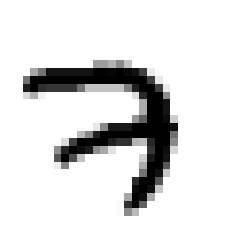

In [6]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a class_names array:

In [7]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [8]:
print(f'Training shape: {X_train.shape}, Validation shape: {X_valid.shape}, Test shape: {X_test.shape}')

Training shape: (55000, 28, 28), Validation shape: (5000, 28, 28), Test shape: (10000, 28, 28)


Let's take a look at a sample of the images in the dataset:

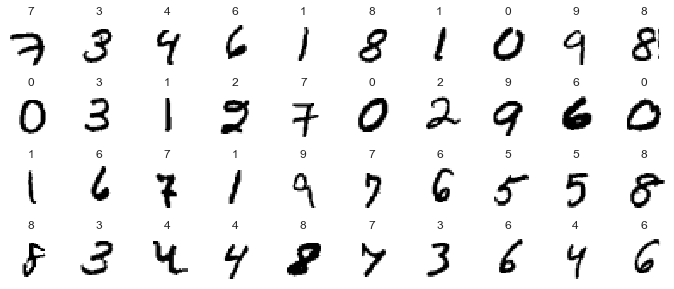

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0 5444]
 [   1 6179]
 [   2 5470]
 [   3 5638]
 [   4 5307]
 [   5 4987]
 [   6 5417]
 [   7 5715]
 [   8 5389]
 [   9 5454]]


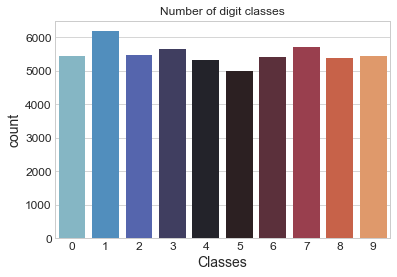

In [11]:
g = sns.countplot(y_train, palette="icefire")
plt.title("Number of digit classes")
plt.xlabel("Classes");

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [12]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [13]:
keras.backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 10 epoch:

In [15]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 3s 2ms/step - loss: 5639.9948 - accuracy: 0.4962 - val_loss: 2.3636 - val_accuracy: 0.1002


Text(0, 0.5, 'Loss')

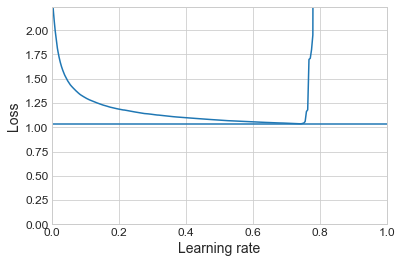

In [16]:
plt.plot(expon_lr.rates, expon_lr.losses)
# plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
# plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.axis([0, 1, 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently around 3e-1, so let's try using 0.7 as our learning rate:

In [17]:
keras.backend.clear_session()
np.random.seed(1)
tf.random.set_seed(1)

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.7),
              metrics=["accuracy"])

In [19]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [20]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6487 - accuracy: 0.8076 - val_loss: 0.2118 - val_accuracy: 0.9468
Epoch 2/100
1719/1719 [==============================] - 2s 946us/step - loss: 0.1547 - accuracy: 0.9556 - val_loss: 0.2131 - val_accuracy: 0.9448
Epoch 3/100
1719/1719 [==============================] - 2s 946us/step - loss: 0.1131 - accuracy: 0.9666 - val_loss: 0.1272 - val_accuracy: 0.9680
Epoch 4/100
1719/1719 [==============================] - 2s 942us/step - loss: 0.0942 - accuracy: 0.9722 - val_loss: 0.1395 - val_accuracy: 0.9658
Epoch 5/100
1719/1719 [==============================] - 2s 948us/step - loss: 0.0952 - accuracy: 0.9718 - val_loss: 0.1205 - val_accuracy: 0.9706
Epoch 6/100
1719/1719 [==============================] - 2s 956us/step - loss: 0.0787 - accuracy: 0.9768 - val_loss: 0.1472 - val_accuracy: 0.9656
Epoch 7/100
1719/1719 [==============================] - 2s 996us/step - loss: 0.0693 - accuracy: 0.9797 - val_loss: 0.1

In [21]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 667us/step - loss: 0.1163 - accuracy: 0.9723


[0.116269, 0.972300]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [22]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir=./my_mnist_logs --port=6006

Reusing TensorBoard on port 6006 (pid 9204), started 2:29:44 ago. (Use '!kill 9204' to kill it.)

In [24]:
y_pred = model.predict(X_test)
y_pred.shape

(10000, 10)

In [25]:
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_pred_classes.shape

(10000,)

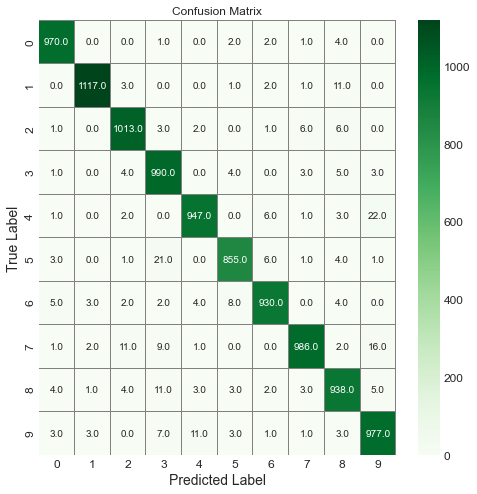

In [26]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [27]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [28]:
from sklearn.metrics import classification_report
target_names = [str(i) for i in np.unique(y_test)]

print('Classification report:')
print(classification_report(y_test, y_pred_classes, target_names=target_names))

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.95      0.98      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.97      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## CNN - Keras

In [29]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [30]:
# Normalize the data
X_train = X_train_full / 255.0
X_test = X_test / 255.0
print("x_train shape: ",X_train.shape)
print("x_test shape: ",X_test.shape)

x_train shape:  (60000, 28, 28)
x_test shape:  (10000, 28, 28)


In [31]:
# Reshape
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("x_test shape: ",X_test.shape)

x_train shape:  (60000, 28, 28, 1)
x_test shape:  (10000, 28, 28, 1)


In [32]:
# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y_train = to_categorical(y_train_full, num_classes = 10)

In [33]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=1)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_val shape",Y_val.shape)

x_train shape (54000, 28, 28, 1)
x_val shape (6000, 28, 28, 1)
y_train shape (54000, 10)
y_val shape (6000, 10)


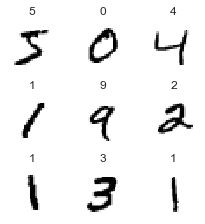

In [34]:
n_rows = 3
n_cols = 3
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train_full[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [36]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [37]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [38]:
epochs = 50  # for better result increase the epochs
batch_size = 250

In [39]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [40]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/50
216/216 [==============================] - 12s 53ms/step - loss: 1.3726 - accuracy: 0.5345 - val_loss: 0.1645 - val_accuracy: 0.9535
Epoch 2/50
216/216 [==============================] - 12s 55ms/step - loss: 0.3814 - accuracy: 0.8807 - val_loss: 0.1095 - val_accuracy: 0.9682
Epoch 3/50
216/216 [==============================] - 12s 55ms/step - loss: 0.2717 - accuracy: 0.9147 - val_loss: 0.0930 - val_accuracy: 0.9708
Epoch 4/50
216/216 [==============================] - 11s 51ms/step - loss: 0.2299 - accuracy: 0.9275 - val_loss: 0.0782 - val_accuracy: 0.9750
Epoch 5/50
216/216 [==============================] - 11s 51ms/step - loss: 0.1970 - accuracy: 0.9391 - val_loss: 0.0724 - val_accuracy: 0.9772
Epoch 6/50
216/216 [==============================] - 12s 56ms/step - loss: 0.1767 - accuracy: 0.9446 - val_loss: 0.0684 - val_accuracy: 0.9788
Epoch 7/50
216/216 [==============================] - 12s 55ms/step - loss: 0.1749 - accuracy: 0.9465 - val_loss: 0.0589 - val_accuracy:

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

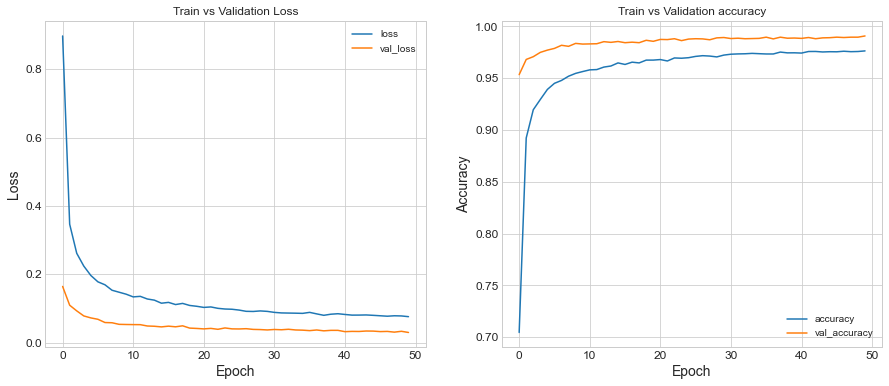

In [42]:
df = pd.DataFrame(history.history)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))
df[['loss', 'val_loss']].plot(ax = axes[0], title = 'Train vs Validation Loss')
df[['accuracy', 'val_accuracy']].plot(ax = axes[1], title = 'Train vs Validation accuracy')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
plt.show()

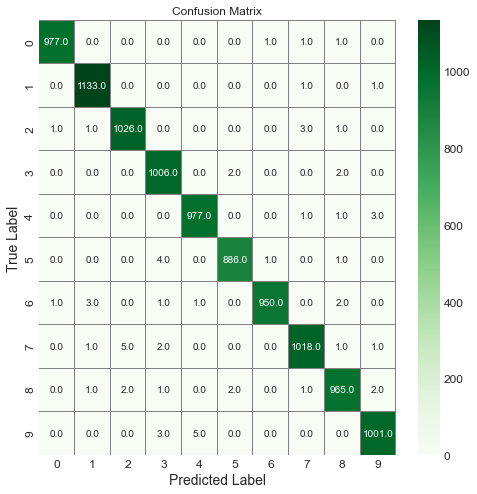

In [43]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = y_test 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [44]:
target_names = [str(i) for i in np.unique(Y_true)]

print('Classification report:')
print(classification_report(Y_true, Y_pred_classes, target_names=target_names))

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [45]:
incorrects = np.nonzero(Y_pred_classes != y_test)
incorrects

(array([  18,  449,  582,  583,  625,  659,  674,  726,  947, 1014, 1033,
        1039, 1226, 1232, 1393, 1709, 1878, 1901, 2035, 2043, 2130, 2135,
        2237, 2447, 2462, 2597, 2654, 3337, 3422, 3762, 3808, 3985, 4078,
        4176, 4238, 4497, 4507, 4740, 4761, 4823, 4860, 5654, 5955, 6555,
        6558, 6559, 6571, 6572, 6578, 6597, 6625, 7902, 8094, 8316, 8325,
        8382, 8408, 9015, 9505, 9679, 9729], dtype=int64),)

In [46]:
prd = model.predict_classes(X_test)
prd[18]

8

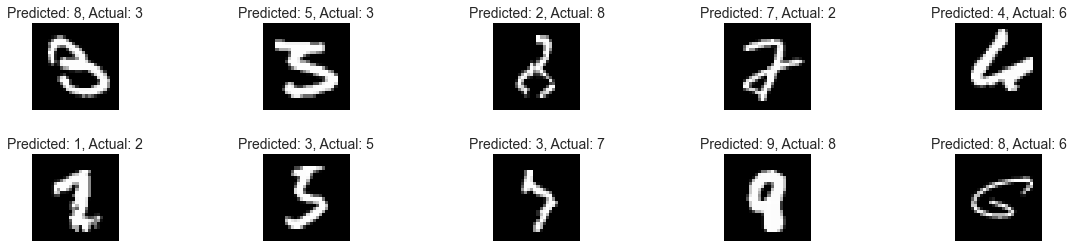

In [47]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, Y_pred_classes):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:10]):
    plt.subplot(2, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test[badIndex], (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(prd[badIndex], y_test[badIndex]), fontsize = 14)
    
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()